In [28]:
import re
from datasets import Dataset, DatasetDict
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:

import pandas as pd
data = pd.read_excel(r'C:\Users\admin\Desktop\traini\newsdata.xlsx')

print(data)

                                                  text  \
0    Exclusive: Boeing deliveries to China delayed ...   
1    Not all Fed officials favored tapering of bala...   
2    SandP 500 to end 2024 around current levels af...   
3    Cancer victims sue Johnson and Johnson over 'f...   
4    Fed shifts talk to 'scenarios' as policy grows...   
..                                                 ...   
170  Bird Flu Cases Spur Retail Trader Rush Into Va...   
171  KKR-Backed Simon and Schuster Asks to Delay to...   
172  Wind towers crumpled after Iowa wind farm suff...   
173  Charles Schwab to Roll Out Alternatives Platfo...   
174  KKR, TPG Said to Weigh PropertyGuru Options In...   

                            target  
0                  Regulatory News  
1                  Regulatory News  
2            Stock market updates   
3    Bankruptcy/ financial distres  
4                  Regulatory News  
..                             ...  
170           Stock market updates  
171    

In [23]:
data['target'] = data['target'].str.lower().str.strip()

In [24]:
target_target = data['target']
print(target_target)

0                    regulatory news
1                    regulatory news
2               stock market updates
3      bankruptcy/ financial distres
4                    regulatory news
                   ...              
170             stock market updates
171                financial results
172                  project updates
173               new product launch
174           merger and acquisition
Name: target, Length: 175, dtype: object


In [25]:
data['targetId'] = data['target'].factorize()[0]
data.head()

,text,target,targetId
0,Exclusive: Boeing deliveries to China delayed ...,regulatory news,0
1,Not all Fed officials favored tapering of bala...,regulatory news,0
2,SandP 500 to end 2024 around current levels af...,stock market updates,1
3,Cancer victims sue Johnson and Johnson over 'f...,bankruptcy/ financial distres,2
4,Fed shifts talk to 'scenarios' as policy grows...,regulatory news,0


In [26]:
target = data[['target', 'targetId']].drop_duplicates().sort_values('targetId')
print(target)

                            target  targetId
0                  regulatory news         0
2             stock market updates         1
3    bankruptcy/ financial distres         2
5                    currency news         3
7           merger and acquisition         4
9      international trade updates         5
11         corporate legal affairs         6
14              new product launch         7
16   industry and economic updates         8
30               financial results         9
31                      investment        10
44                   joint venture        11
47           other company updates        12
141                project updates        13


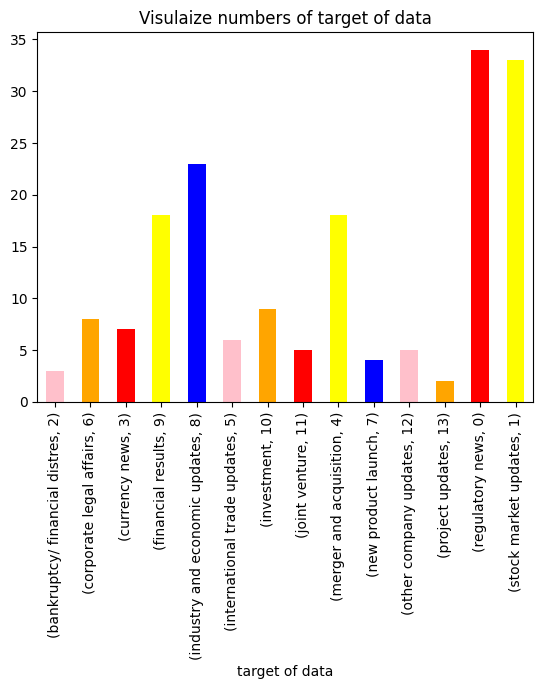

In [27]:
data.groupby('target').targetId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("target of data")
plt.title("Visulaize numbers of target of data")
plt.show()

In [8]:
def remove_tags(text):
    remove = re.compile(r'')
    return re.sub(remove, '', text)
data['text'] = data['text'].apply(remove_tags)
print(data["text"][1])

Not all Fed officials favored tapering of balance sheet contraction proces


In [9]:
def special_char(text):
    reviews = ''
    for x in text:
        if x.isalnum():
            reviews = reviews + x
        else:
            reviews = reviews + ' '
    return reviews
data['text'] = data['text'].apply(special_char)

In [10]:
def convert_lower(text):
    return text.lower()
data['text'] = data['text'].apply(convert_lower)
data['text'][1]

'not all fed officials favored tapering of balance sheet contraction proces'

In [11]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return ' '.join([x for x in words if x not in stop_words])
data['text'] = data['text'].apply(remove_stopwords) 
data['text'][1]

'fed officials favored tapering balance sheet contraction proces'

In [12]:
# Verify the number of unique labels
num_labels = data['targetId'].nunique()
print(f'Number of unique labels: {num_labels}')

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['targetId'], random_state=42)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("MoritzLaurer/roberta-large-zeroshot-v2.0-c")

# Tokenize the text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text", "__index_level_0__"])
tokenized_datasets = tokenized_datasets.rename_column("targetId", "labels")
tokenized_datasets.set_format("torch")

# Print train_data and train_dataset for inspection
print(train_data.head())
print(train_dataset)

Number of unique labels: 14


Map: 100%|██████████| 35/35 [00:00<00:00, 4898.58 examples/s]

                                                  text  \
88   oil extends decline fourth sesion hawkish fed ...   
119  singapore maintains 2024 economic growth view ...   
6    us lawmakers advance bill make easier curb exp...   
167  mubadala offers sell 950 million globalfoundri...   
115  troubled peru copper mine starts expansion wor...   

                            target  targetId  
88            stock market updates         1  
119  industry and economic updates         8  
6                  regulatory news         0  
167           stock market updates         1  
115  industry and economic updates         8  
Dataset({
    features: ['text', 'target', 'targetId', '__index_level_0__'],
    num_rows: 140
})


In [13]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./saved_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    report_to=[]  
)

# Load the model with the correct number of labels
model = AutoModelForSequenceClassification.from_pretrained("MoritzLaurer/roberta-large-zeroshot-v2.0-c", num_labels=num_labels,ignore_mismatched_sizes=True)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
 
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)
# Save the model and tokenizer
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

print("Model and tokenizer saved to ./saved_model")

c:\Users\admin\Desktop\traini\autotrain-env\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/roberta-large-zeroshot-v2.0-c and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([14]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([14, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                  
 10%|█         | 18/180 [12:36<1:30:17, 33.44s/it]

{'eval_loss': 2.301523447036743, 'eval_runtime': 74.057, 'eval_samples_per_second': 0.473, 'eval_steps_per_second': 0.068, 'epoch': 1.0}


                                                  
 20%|██        | 36/180 [25:11<1:20:29, 33.54s/it]

{'eval_loss': 2.270287275314331, 'eval_runtime': 74.2031, 'eval_samples_per_second': 0.472, 'eval_steps_per_second': 0.067, 'epoch': 2.0}


                                                  
 30%|███       | 54/180 [38:27<1:10:24, 33.53s/it]

{'eval_loss': 2.214810609817505, 'eval_runtime': 74.8106, 'eval_samples_per_second': 0.468, 'eval_steps_per_second': 0.067, 'epoch': 3.0}


                                                  
 40%|████      | 72/180 [51:02<1:00:13, 33.46s/it]

{'eval_loss': 2.125486135482788, 'eval_runtime': 74.4959, 'eval_samples_per_second': 0.47, 'eval_steps_per_second': 0.067, 'epoch': 4.0}


                                                    
 50%|█████     | 90/180 [1:03:36<50:02, 33.36s/it]

{'eval_loss': 2.049968957901001, 'eval_runtime': 74.8716, 'eval_samples_per_second': 0.467, 'eval_steps_per_second': 0.067, 'epoch': 5.0}


                                                    
 60%|██████    | 108/180 [1:16:09<39:58, 33.31s/it]

{'eval_loss': 2.0652759075164795, 'eval_runtime': 74.7545, 'eval_samples_per_second': 0.468, 'eval_steps_per_second': 0.067, 'epoch': 6.0}


                                                     
 70%|███████   | 126/180 [1:28:43<30:10, 33.53s/it]

{'eval_loss': 2.025705575942993, 'eval_runtime': 75.0875, 'eval_samples_per_second': 0.466, 'eval_steps_per_second': 0.067, 'epoch': 7.0}


                                                   
 80%|████████  | 144/180 [1:41:25<20:12, 33.68s/it]

{'eval_loss': 1.9972642660140991, 'eval_runtime': 75.0434, 'eval_samples_per_second': 0.466, 'eval_steps_per_second': 0.067, 'epoch': 8.0}


                                                   
 90%|█████████ | 162/180 [1:54:05<10:01, 33.41s/it]

{'eval_loss': 2.0156426429748535, 'eval_runtime': 75.0761, 'eval_samples_per_second': 0.466, 'eval_steps_per_second': 0.067, 'epoch': 9.0}


                                                   
100%|██████████| 180/180 [2:06:42<00:00, 42.23s/it]


{'eval_loss': 1.9883453845977783, 'eval_runtime': 74.9257, 'eval_samples_per_second': 0.467, 'eval_steps_per_second': 0.067, 'epoch': 10.0}
{'train_runtime': 7602.2315, 'train_samples_per_second': 0.184, 'train_steps_per_second': 0.024, 'train_loss': 1.8491690741644966, 'epoch': 10.0}


100%|██████████| 5/5 [00:57<00:00, 11.54s/it]


{'eval_loss': 1.9883453845977783, 'eval_runtime': 74.7786, 'eval_samples_per_second': 0.468, 'eval_steps_per_second': 0.067, 'epoch': 10.0}
Model and tokenizer saved to ./saved_model
